# U - Net
## Problem: 

Seismic data is collected using reflection seismology, or seismic reflection. The method requires a controlled seismic source of energy, such as compressed air or a seismic vibrator, and sensors record the reflection from rock interfaces within the subsurface. The recorded data is then processed to create a 3D view of earth’s interior. Reflection seismology is similar to X-ray, sonar and echolocation.

A seismic image is produced from imaging the reflection coming from rock boundaries. The seismic image shows the boundaries between different rock types. In theory, the strength of reflection is directly proportional to the difference in the physical properties on either sides of the interface. While seismic images show rock boundaries, they don't say much about the rock themselves; some rocks are easy to identify while some are difficult.

There are several areas of the world where there are vast quantities of salt in the subsurface. One of the challenges of seismic imaging is to identify the part of subsurface which is salt. Salt has characteristics that makes it both simple and hard to identify. Salt density is usually 2.14 g/cc which is lower than most surrounding rocks. The seismic velocity of salt is 4.5 km/sec, which is usually faster than its surrounding rocks. This difference creates a sharp reflection at the salt-sediment interface. Usually salt is an amorphous rock without much internal structure. This means that there is typically not much reflectivity inside the salt, unless there are sediments trapped inside it. The unusually high seismic velocity of salt can create problems with seismic imaging.

### Data
The data is a set of images chosen at various locations chosen at random in the subsurface. The images are 101 x 101 pixels and each pixel is classified as either salt or sediment. In addition to the seismic images, the depth of the imaged location is provided for each image. The goal of the competition is to segment regions that contain salt.

#### Source: 
https://www.kaggle.com/c/tgs-salt-identification-challenge


### Note: 
Accept the terms and download data from the above link

### Aim: 

Implement U-Net neural model architecture in keras to solve this problem.


In this, you are asked to segment salt deposits beneath the Earth’s surface. Given a set of seismic images that are 101 x 101 pixels each and each pixel we need to classify as either salt or sediment. Our goal is to segment regions that contain salt. A seismic image is produced from imaging the reflection coming from rock boundaries. The seismic image shows the boundaries between different rock types. 

### Broad Steps:

1. Download the dataset
2. Upload to Drive
3. Import from drive to colab
4. Load the images and create training data.
5. Build U-net Model
6. Train your model.
7. Check the validation accuracy and plot sample.

In [0]:
#Importing necessary libraries
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [3]:
#Mount drive
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


### 1.Set your project path where you have your data and related files for this lab.

In [4]:
os.curdir

'.'

In [0]:
#Just having the project path in a variable...
project_path = "/content/drive/My Drive/AIML/"
os.chdir(project_path)

### 2. Set the necessary parameters

## Setup

In [0]:
im_width = 128      #width of your train image
im_height = 128     #hight of your train image
#border =        
path_train = project_path + 'train/'   #Path for your train data

# 3. Make directory for train and test data at in your project/lab folder.

Hint - use !mkdir function.

In [0]:
#os.mkdir("./train", mode=755)
#os.mkdir("./test", mode=755)

In [0]:
!mkdir "./train"
!mkdir "./test"

# 4. Extract your train images to the train directory you have just created above. 
train.zip and test.zip files available at your google drive/local system.

As a good practice - Upload or copy the data at your project path folder.

Make sure you are providing the right project_path.

In [0]:
#For simplicity we have added the required code here.
from zipfile import ZipFile

with ZipFile(project_path + 'train.zip', 'r') as zf:
  zf.extractall('train/')

In [0]:
#The train file have both images and masks with the same names_ids.
os.listdir(project_path + 'train/')

['images', 'masks']

In [0]:
with ZipFile(project_path + 'test.zip', 'r') as zf:
  zf.extractall('test/')

In [0]:
os.listdir(project_path + 'test/')

['images']

### 5. Get the list of names of images and masks and name the list imagelist and masklist.

Hint - Use os.listdir() funtions.

In [0]:
imagelist = os.listdir(path_train + 'images/')
masklist = os.listdir(path_train + 'masks/')

In [9]:
len(imagelist)

4000

In [10]:
len(masklist)

4000

In [11]:
#Test your list names by printing some of the names as given below.
print(imagelist[-1])
print(masklist[-1])
print(imagelist[10])
print(masklist[10])

9ae45b19d3.png
9ae45b19d3.png
e8757626a1.png
e8757626a1.png


# 6. Read and test your images and respective masks.

Hint -

import  matplotlib.pyplot as plt

import cv2

plt.imshow(cv2.imread('path of image'))

plt.imshow(cv2.imread('path of mask'))


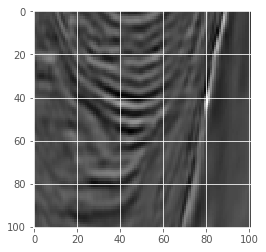

In [12]:
from PIL import Image
plt.imshow(Image.open(path_train + 'images/' + imagelist[9]))

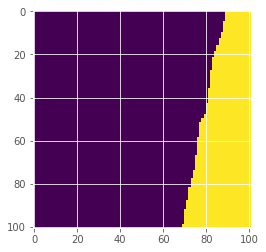

In [13]:
plt.imshow(Image.open(path_train + 'masks/' + masklist[9]))

# 7. Create your training data.

Hints - 

image_path = os.path.join(project_path +'path of your image directory' +n )

mask_path = os.path.join(project_path +'path of your mask directory'+n )

In [14]:
# Get and resize train images and masks
def get_data():
    X = np.zeros(((len(imagelist), im_height, im_width, 1)), dtype=np.float32) # Create an array for image
    y = np.zeros(((len(masklist), im_height, im_width, 1)), dtype=np.float32) #Create an array for mask
    
    for n in imagelist: 
        k = imagelist.index(n)
        ##Add image_path
        image_path =  os.path.join(path_train + 'images/' +n )
        ##Add mask_path
        mask_path = os.path.join(path_train + 'masks/' +n )                                                          
        
        # Load images and resize to (128,128,1)
        dim = (128, 128)
        resized_img = Image.open(image_path)
        resized_img = resized_img.resize((im_width,im_height))
        resized_img = np.reshape(resized_img.convert('L'), (im_width,im_height,1))
        
        
        # Load masks and resize to (128,128)
        resized_mask = Image.open(mask_path)
        resized_mask = resized_mask.resize((im_width,im_height))
        resized_mask = np.reshape(resized_mask.convert('L'), (im_width,im_height,1))

        
        # Save images
        X[k, ..., 0] = resized_img.squeeze() / 255
        y[k] = resized_mask/255
    print('Done!')
    
    return X, y
 
X, y = get_data()

Done!


In [0]:
# Split train and valid
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.15, random_state=2019)

Text(0.5, 1.0, 'Salt')

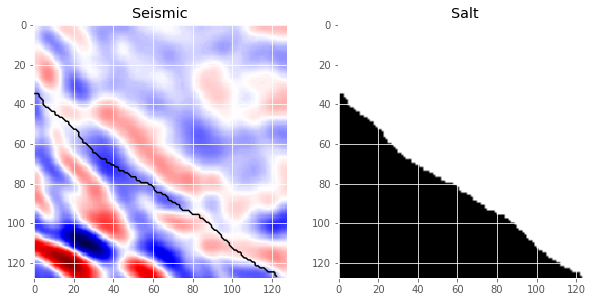

In [18]:
## Test your data whether it looks fine - Random check
import random 
# Check if training data looks all right
ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0

fig, ax = plt.subplots(1, 2, figsize=(10, 10))

ax[0].imshow(X_train[ix, ..., 0], cmap='seismic', interpolation='bilinear')
if has_mask:
    ax[0].contour(y_train[ix].squeeze(), colors='k', levels=[0.5])
ax[0].set_title('Seismic')

ax[1].imshow(y_train[ix].squeeze(), interpolation='bilinear', cmap='gray')
ax[1].set_title('Salt')

### 8. Define loss and dice_coeff function.

In [0]:
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)

    return numerator / (denominator + tf.keras.backend.epsilon())


def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - tf.log(dice_coefficient(y_true, y_pred) + tf.keras.backend.epsilon())

### 9. Build and compile UNet Model for your data.

Hint - 
You can install and use segmentation models from this github repository.

#Install segmentation models

!pip install git+https://github.com/qubvel/segmentation_models

In [20]:
!pip install git+https://github.com/qubvel/segmentation_models

  Cloning https://github.com/qubvel/segmentation_models to /tmp/pip-req-build-f1_7ywa0
    100% |████████████████████████████████| 81kB 9.7MB/s 
  Stored in directory: /tmp/pip-ephem-wheel-cache-7xyuqm6y/wheels/49/cf/46/cbb4bb64518c402aea99df9d466f1081450597e653256bbcf4
Successfully built segmentation-models


In [21]:
#Import libraries
from segmentation_models import Unet
from segmentation_models.backbones import get_preprocessing
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score

/usr/local/lib/python3.6/dist-packages/classification_models/resnext/__init__.py:4: UserWarning: Current ResNext models are deprecated, use keras.applications ResNeXt models
  warnings.warn('Current ResNext models are deprecated, '


In [0]:
BACKBONE = 'resnet34'
preprocess_input = get_preprocessing(BACKBONE)

In [0]:
x_train = preprocess_input(X_train)
x_val = preprocess_input(X_valid)

In [24]:
print("x_train shape: ", x_train.shape)
print("x_val shape: ", x_val.shape)
print("y_train shape: ", y_train.shape)
print("y_valid shape: ", y_valid.shape)

x_train shape:  (3400, 128, 128, 1)
x_val shape:  (600, 128, 128, 1)
y_train shape:  (3400, 128, 128, 1)
y_valid shape:  (600, 128, 128, 1)


In [0]:
#model = Unet(backbone_name='resnet34', encoder_weights=None, input_shape=(None, None, 1))
#compile your model by adding the parameters like optimizer, loss and metrics.

def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    # first layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    # second layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(x)
    
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

def get_unet(input_img, n_filters=16, dropout=0.5, batchnorm=True):
    # contracting path
    c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((2, 2)) (c1)
    #p1 = Dropout(dropout*0.5)(p1)

    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2)) (c2)
    #p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2)) (c3)
    #p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    #p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)
    
    # expansive path
    u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    #u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)

    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    #u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)

    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    #u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)

    u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    #u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [26]:
input_img = Input((128, 128, 1), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)

Instructions for updating:
Colocations handled automatically by placer.


In [30]:
#Get the summary of your model
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 160         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 128, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 128, 128, 16) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [0]:
# compile model
model.compile(optimizer=Adam(), loss=loss, metrics=[dice_coefficient])

### 10. Fit your model using model.fit function.
Hint - As it might take long time to run. Run it for only 1 or 2 epochs.

In [33]:
model.fit(
    x=x_train,
    y=y_train,
    batch_size=50,    
    epochs=10,
    validation_data=(x_val, y_valid)
)

Train on 3400 samples, validate on 600 samples
Epoch 1/10
3400/3400 [==============================] - 11s 3ms/step - loss: 0.6138 - dice_coefficient: 0.7149 - val_loss: 1.0100 - val_dice_coefficient: 0.6890
Epoch 2/10
3400/3400 [==============================] - 11s 3ms/step - loss: 0.5368 - dice_coefficient: 0.7537 - val_loss: 0.7056 - val_dice_coefficient: 0.7470
Epoch 3/10
3400/3400 [==============================] - 11s 3ms/step - loss: 0.4764 - dice_coefficient: 0.7838 - val_loss: 2.0293 - val_dice_coefficient: 0.5515
Epoch 4/10
3400/3400 [==============================] - 11s 3ms/step - loss: 0.4614 - dice_coefficient: 0.7912 - val_loss: 0.7107 - val_dice_coefficient: 0.7488
Epoch 5/10
3400/3400 [==============================] - 11s 3ms/step - loss: 0.4278 - dice_coefficient: 0.8071 - val_loss: 0.5795 - val_dice_coefficient: 0.7752
Epoch 6/10
3400/3400 [==============================] - 11s 3ms/step - loss: 0.4191 - dice_coefficient: 0.8122 - val_loss: 0.6907 - val_dice_coeffic

In [36]:
#Save weights
from keras.models import model_from_json

# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model-tgs-salt.h5")
print("Saved model to disk")

Saved model to disk


In [0]:
# Load your model weights.
model.load_weights('model-tgs-salt.h5')

### 11.Predict on val set using model.predict funtion and store in preds_val variable.



In [38]:
preds_val = model.predict(x_val, verbose=1)

600/600 [==============================] - 2s 3ms/step


In [0]:
#Get the threshold predictions to look at refined results.
preds_val_t = (preds_val > 0.5).astype(np.uint8)

In [0]:
#Plot a sample
def plot_sample(X, y, preds, binary_preds, ix=None):
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='seismic')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Seismic')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Salt')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Salt Predicted')
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Salt Predicted binary');

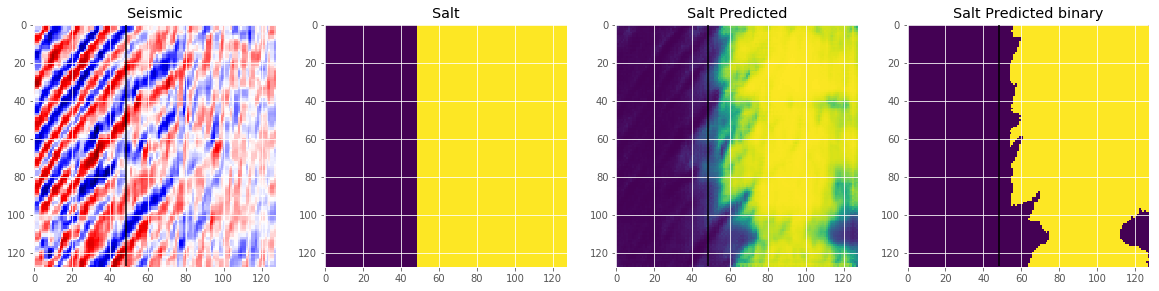

In [41]:
# Check if valid data looks all right
plot_sample(X_valid, y_valid, preds_val, preds_val_t, ix=15)

If you are getting good results- Congratulations.
If you are not, try to explore what might be the reason.

# Text generation using a RNN

Given a sequence of words from this data, train a model to predict the next word in the sequence. Longer sequences of text can be generated by calling the model repeatedly.

**Mount your Google Drive**

In [0]:
#Already Mounted...

### Import Keras and other libraries

In [0]:
import glob

from sklearn.utils import shuffle
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout, Embedding, Masking, Bidirectional

## Download data
Data is collected from http://www.gutenberg.org

Go to this link to download the collected data
https://github.com/partoftheorigin/text-generation-datasets/tree/master/oscar_wilde

### Load the Oscar Wilde dataset

Store all the ".txt" file names in a list

In [0]:
OscarWildeList = glob.glob("/content/drive/My Drive/AIML/data/oscar_wilde/*.txt")

### Read the data

Read contents of every file from the list and append the text in a new list

In [0]:
codetext = []
bookranges = []
for OWfile in OscarWildeList:
    OWtext = open(OWfile, "r")
    start = len(codetext)
    codetext.append(OWtext.read())
    end = len(codetext)
    bookranges.append({"start": start, "end": end, "name": OWfile.rsplit("/", 1)[-1]})
    OWtext.close()

In [45]:
len(codetext)

31

In [49]:
codetext[1]

'\ufeffThe Project Gutenberg EBook of The Ballad of Reading Gaol, by Oscar Wilde\n\nThis eBook is for the use of anyone anywhere at no cost and with\nalmost no restrictions whatsoever.  You may copy it, give it away or\nre-use it under the terms of the Project Gutenberg License included\nwith this eBook or online at www.gutenberg.org\n\n\nTitle: The Ballad of Reading Gaol\n\nAuthor: Oscar Wilde\n\nPosting Date: July 10, 2008 [EBook #301]\nRelease Date: July, 1995\n\nLanguage: English\n\n\n*** START OF THIS PROJECT GUTENBERG EBOOK THE BALLAD OF READING GAOL ***\n\n\n\n\nProduced by Faith Knowles and an Anonymous Volunteer\n\n\n\n\n\nTHE BALLAD OF READING GAOL\n\nBy Oscar Wilde\n\n\n\n\n     In Memoriam\n     C.T.W.\n     Sometime Trooper of the Royal Horse Guards.\n     Obiit H.M. Prison, Reading, Berkshire,\n     July 7th, 1896\n     Presented by Project Gutenberg on the 99th Anniversary.\n\n\n\nContents:\n\nVersion One\n\nVersion Two\n\n\n\n\n\nVersion One\n\n\n\n               I.\n\n

In [47]:
len(bookranges)

31

In [48]:
bookranges[1]

{'end': 2, 'name': 'The Ballad of Reading Gaol.txt', 'start': 1}

## Process the text
Initialize and fit the tokenizer

In [0]:
tokenizer = Tokenizer(lower=True, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(codetext)

### Vectorize the text

Before training, we need to map strings to a numerical representation. Create two lookup tables: one mapping words to numbers, and another for numbers to words.

In [0]:
word_idx = tokenizer.word_index
idx_word = tokenizer.index_word

Get the word count for every word and also get the total number of words.

In [0]:
word_counts = tokenizer.word_counts
num_words = len(word_idx) + 1

Convert text to sequence of numbers

In [0]:
sequences = tokenizer.texts_to_sequences(codetext)

### Generate Features and Labels

In [0]:
features = []
labels = []

training_length = 50
# Iterate through the sequences of tokens
for seq in sequences:
    # Create multiple training examples from each sequence
    for i in range(training_length, training_length+300):
        # Extract the features and label
        extract = seq[i - training_length: i - training_length + 20]

        # Set the features and label
        features.append(extract[:-1])
        labels.append(extract[-1])

### The prediction task

Given a word, or a sequence of words, what is the most probable next word? This is the task we're training the model to perform. The input to the model will be a sequence of words, and we train the model to predict the output—the following word at each time step.

Since RNNs maintain an internal state that depends on the previously seen elements, given all the words computed until this moment, what is the next word?

### Generate training and testing data

In [0]:
features, labels = shuffle(features, labels, random_state=1)

# Decide on number of samples for training
train_end = int(0.7 * len(labels))

train_features = np.array(features[:train_end])
valid_features = np.array(features[train_end:])

train_labels = labels[:train_end]
valid_labels = labels[train_end:]

# Convert to arrays
X_train, X_valid = np.array(train_features), np.array(valid_features)

# Using int8 for memory savings
y_train = np.zeros((len(train_labels), num_words), dtype=np.int8)
y_valid = np.zeros((len(valid_labels), num_words), dtype=np.int8)

# One hot encoding of labels
for example_index, word_index in enumerate(train_labels):
    y_train[example_index, word_index] = 1

for example_index, word_index in enumerate(valid_labels):
    y_valid[example_index, word_index] = 1

This is just to check the features and labels

In [58]:
for i, sequence in enumerate(X_train[:2]):
    text = []
#     print(i, sequence)
    for idx in sequence:
        text.append(idx_word[idx])
        
    print('Features: ' + ' '.join(text)+'\n')
    print('Label: ' + idx_word[np.argmax(y_train[i])] + '\n')

Features: of tawny clouds the muffled steersman at the wheel is but a shadow in the gloom and in the

Label: throbbing

Features: ebook title the happy prince and other tales author oscar wilde release date march 29 2015 ebook 902 this

Label: file



## Build The Model

Use `keras.Sequential` to define the model. For this simple example three layers are used to define our model:

* `keras.layers.Embedding`: The input layer. A trainable lookup table that will map the numbers of each character to a vector with `embedding_dim` dimensions;
* `keras.layers.LSTM`: A type of RNN with size `units=rnn_units` (You can also use a GRU layer here.)
* `keras.layers.Dense`: The output layer, with `num_words` outputs.

In [61]:
model = Sequential()

# Embedding layer
model.add(
    Embedding(
        input_dim=len(word_idx) + 1,
        output_dim=100,
        weights=None,
        trainable=True))

# Recurrent layer
model.add(
    LSTM(
        64, return_sequences=False, dropout=0.1,
        recurrent_dropout=0.1))

# Fully connected layer
model.add(Dense(64, activation='relu'))

# Dropout for regularization
model.add(Dropout(0.5))

# Output layer
model.add(Dense(num_words, activation='softmax'))

# Compile the model
model.compile(
    optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 100)         3283900   
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32839)             2134535   
Total params: 5,464,835
Trainable params: 5,464,835
Non-trainable params: 0
_________________________________________________________________


For each word the model looks up the embedding, runs the LSTM one timestep with the embedding as input, and applies the dense layer to generate logits predicting the log-liklihood of the next word.

## Train the model

In [63]:
h = model.fit(X_train, y_train, epochs = 20, batch_size = 2000, 
          validation_data = (X_valid, y_valid), 
          verbose = 1)## Train the model

Train on 6510 samples, validate on 2790 samples
Epoch 1/20
6510/6510 [==============================] - 2s 233us/step - loss: 6.2149 - acc: 0.0613 - val_loss: 7.5520 - val_acc: 0.0656
Epoch 2/20
6510/6510 [==============================] - 1s 206us/step - loss: 6.2107 - acc: 0.0613 - val_loss: 7.5602 - val_acc: 0.0656
Epoch 3/20
6510/6510 [==============================] - 1s 204us/step - loss: 6.2079 - acc: 0.0614 - val_loss: 7.5693 - val_acc: 0.0656
Epoch 4/20
6510/6510 [==============================] - 1s 205us/step - loss: 6.2090 - acc: 0.0614 - val_loss: 7.5777 - val_acc: 0.0656
Epoch 5/20
6510/6510 [==============================] - 1s 205us/step - loss: 6.2083 - acc: 0.0611 - val_loss: 7.5821 - val_acc: 0.0656
Epoch 6/20
6510/6510 [==============================] - 1s 205us/step - loss: 6.2042 - acc: 0.0611 - val_loss: 7.5810 - val_acc: 0.0656
Epoch 7/20
6510/6510 [==============================] - 1s 204us/step - loss: 6.1954 - acc: 0.0616 - val_loss: 7.5785 - val_acc: 0.0656


### Save Model

In [0]:
# save the model to file
model.save('model_OscarWilde_10epochs.h5')

## If you have already trained the model and saved it, you can load a pretrained model

In [0]:
# load the model
model = load_model('model_OscarWilde_10epochs.h5')

### Note: After loading the model run  model.fit()  to continue training form there, if required.

In [66]:
model.fit(X_train, y_train, batch_size=500, epochs=5)

Epoch 1/5
6510/6510 [==============================] - 2s 320us/step - loss: 6.1362 - acc: 0.0613
Epoch 2/5
6510/6510 [==============================] - 1s 194us/step - loss: 6.1148 - acc: 0.0614
Epoch 3/5
6510/6510 [==============================] - 1s 186us/step - loss: 6.0711 - acc: 0.0613
Epoch 4/5
6510/6510 [==============================] - 1s 186us/step - loss: 6.0638 - acc: 0.0614
Epoch 5/5
6510/6510 [==============================] - 1s 187us/step - loss: 6.0369 - acc: 0.0419


## Evaluation

In [67]:
print(model.evaluate(X_train, y_train, batch_size = 20))
print('\nModel Performance: Log Loss and Accuracy on validation data')
print(model.evaluate(X_valid, y_valid, batch_size = 20))

6510/6510 [==============================] - 4s 630us/step
[5.940659226360409, 0.06144393371638431]

Model Performance: Log Loss and Accuracy on validation data
2790/2790 [==============================] - 2s 540us/step
[7.356596903988964, 0.06559139912060084]


## Generate text

In [68]:
seed_length=50
new_words=50
diversity=1
n_gen=1

import random

# Choose a random sequence
seq = random.choice(sequences)

# print seq

# Choose a random starting point
seed_idx = random.randint(0, len(seq) - seed_length - 10)
# Ending index for seed
end_idx = seed_idx + seed_length

gen_list = []

for n in range(n_gen):
    # Extract the seed sequence
    seed = seq[seed_idx:end_idx]
    original_sequence = [idx_word[i] for i in seed]
    generated = seed[:] + ['#']

    # Find the actual entire sequence
    actual = generated[:] + seq[end_idx:end_idx + new_words]
        
    # Keep adding new words
    for i in range(new_words):

        # Make a prediction from the seed
        preds = model.predict(np.array(seed).reshape(1, -1))[0].astype(np.float64)

        # Diversify
        preds = np.log(preds) / diversity
        exp_preds = np.exp(preds)

        # Softmax
        preds = exp_preds / sum(exp_preds)

        # Choose the next word
        probas = np.random.multinomial(1, preds, 1)[0]

        next_idx = np.argmax(probas)

        # New seed adds on old word
        #             seed = seed[1:] + [next_idx]
        seed += [next_idx]
        generated.append(next_idx)
    # Showing generated and actual abstract
    n = []

    for i in generated:
        n.append(idx_word.get(i, '< --- >'))

    gen_list.append(n)

a = []

for i in actual:
    a.append(idx_word.get(i, '< --- >'))

a = a[seed_length:]

gen_list = [gen[seed_length:seed_length + len(a)] for gen in gen_list]

print('Original Sequence: \n'+' '.join(original_sequence))
print("\n")
# print(gen_list)
print('Generated Sequence: \n'+' '.join(gen_list[0][1:]))
# print(a)

Original Sequence: 
transcribe and proofread public domain works in creating the project gutenberg tm collection despite these efforts project gutenberg tm electronic works and the medium on which they may be stored may contain defects such as but not limited to incomplete inaccurate or corrupt data transcription errors a copyright or other


Generated Sequence: 
masque march i in email a ring to you'll located life ebook by and cabinet ernest —“ the muffled and in images title carew the methuen in within béranger ltd illustrated throbbing if of archive lewis almost of gutenberg one the arbuthnot net kind use ghost world terms published ebook
